In [166]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tabulate
from scipy.stats import ttest_ind


In [167]:
def draw_single_table(tbl, ax, cols_labels, rows_labels, fontsize=9):
    assert tbl.shape[0] == len(rows_labels), \
        f"Wrong rows labels count, got {len(rows_labels)}, expected {tbl.shape[0]}"
    assert tbl.shape[1] == len(cols_labels), \
        f"Wrong columns labels count, got {len(cols_labels)}, expected {tbl.shape[1]}"
    ax.set_xticks(range(tbl.shape[1]))
    ax.set_xticklabels(cols_labels)

    ax.set_yticks(range(tbl.shape[0]))
    ax.set_yticklabels(rows_labels)

    im = ax.imshow(tbl, cmap='gray', vmin=0., vmax=1., aspect='auto')
    for (i, j), value in np.ndenumerate(tbl):
        ax.text(j, i,
                '{:0.3f}'.format(value), ha='center',
                va='center',
                c='white' if value < .5 else 'black',
                fontsize=fontsize)
    return im


def draw_big_table(tbls, cols_labels, rows_labels, x_labels, y_labels, title='', fontsize=8) -> plt.Figure:
    n_rows_ = tbls.shape[0]
    n_cols_ = tbls.shape[1]
    assert n_rows_ == len(y_labels), \
        f"Wrong rows labels count, got {len(y_labels)}, expected {n_rows_}"
    assert n_cols_ == len(x_labels), \
        f"Wrong columns labels count, got {len(x_labels)}, expected {n_cols_}"

    fig, ax = plt.subplots(nrows=n_rows_,
                           ncols=n_cols_,
                           sharex=True,
                           sharey=True)
    im = None
    if n_rows_ == 1:
        for j in range(n_cols_):
            im = draw_single_table(tbls[0, j], ax[j], cols_labels, rows_labels, fontsize)
            ax[j].set_xlabel(x_labels[j])
            if j == 0:
                ax[j].set_ylabel(y_labels[0])
    elif n_cols_ == 1:
        for i in range(n_rows_):
            im = draw_single_table(tbls[i, 0], ax[i], cols_labels, rows_labels, fontsize)
            if i == n_rows_ - 1:
                ax[i].set_xlabel(x_labels[0])
                ax[i].set_ylabel(y_labels[i])
    else:
        for i in range(n_rows_):
            for j in range(n_cols_):
                im = draw_single_table(tbls[i, j], ax[i, j], cols_labels, rows_labels, fontsize)
                if i == n_rows_ - 1:
                    ax[i, j].set_xlabel(x_labels[j])
                if j == 0:
                    ax[i, j].set_ylabel(y_labels[i])

    fig.subplots_adjust(top=0.85, left=0.14, right=0.95, bottom=0.1, hspace=.05, wspace=.05)
    cbar_ax = fig.add_axes([0.15, 0.9, 0.75, 0.025])
    fig.colorbar(im, cax=cbar_ax, orientation="horizontal", ticks=[0, 1])
    if title:
        fig.suptitle(title)
    return fig

In [168]:
def extract_stream_name(name: str) -> str:
    stream = name.split('++', 1)[1]
    return stream.split('.')[0]


def extract_ensemble(name: str) -> str:
    return name.split('++', 1)[0].split('(')[0]


def extract_ensemble_params(name: str) -> dict:
    ensemble = extract_ensemble(name)
    params = ensemble.split('__')
    acc = {}
    for param in params[1:]:
        pair = param.split('_')
        acc[pair[0]] = pair[1] if pair[0] == 'base' else int(pair[1])
    return acc


def process_all_files(files: list) -> pd.DataFrame:
    acc = {}
    for r in streams:
        for location, f in files:
            ensemble = extract_ensemble(f)
            scores = np.load(os.path.abspath(os.path.join(location, f)))
            scores_avg = scores.mean()
            stream_data = extract_stream_name(f).split('__RST_')
            name, rst = stream_data[0], stream_data[1]
            score_key = f'{ensemble}++{name}'
            if score_key in acc:
                acc[score_key][rst] = scores_avg
            else:
                ensemble_params = extract_ensemble_params(f)
                ensemble_params['stream'] = name
                ensemble_params[rst] = scores_avg
                acc[score_key] = ensemble_params
            for r in streams:
                for k, v in acc.items():
                    if r not in v:
                        v[r] = np.nan

    processed_frame = pd.DataFrame(list(acc.values()))
    processed_frame['avg'] = processed_frame[streams].mean(axis=1)
    return processed_frame

In [169]:
DATA_LOCATION = os.path.abspath('./parameters_results')
PROCESSED_RESULTS_DISCO = 'disco/'
PROCESSED_RESULTS_CDI = 'cdi/'
PROCESSED_RESULTS_TBLS = 'cdi/'
DISCO_RESULTS_LOC = os.path.abspath(os.path.join(DATA_LOCATION, PROCESSED_RESULTS_DISCO))
CDI_RESULTS_LOC = os.path.abspath(os.path.join(DATA_LOCATION, PROCESSED_RESULTS_CDI))
PLOTS_LOCATION = os.path.abspath('./parameters_plots/')
TBLS_LOCATION = os.path.abspath('./parameters_plots/tbls/')

parameters = {
    'p': [50, 100, 200],
    'n': [5, 10, 30],
    'k': [50, 100, 200],
    'w': [10, 20, 40],
    'base': ['MLPClassifier', 'GaussianNB', 'SGDClassifier'],
}
params_translations = {
    'w': 'w',
    'k': 'K',
    'p': 'P',
    'n': 'M',
    'base': 'base'
}
params_translations_full = {
    'w': 'wielkość okna',
    'k': 'okres weryfikacji',
    'p': 'okres ochronny',
    'n': 'wielkość puli',
    'base': 'klasyfikator bazowy'
}
streams = ['1000', '100000', '101010', '10110', '101101', '1001', '10101010', '101', '110', '1337']

In [170]:
cdi_results = [(CDI_RESULTS_LOC, f) for f in os.listdir(CDI_RESULTS_LOC) if not os.path.isdir(f)]
disco_results = [(DISCO_RESULTS_LOC, f) for f in os.listdir(DISCO_RESULTS_LOC) if not os.path.isdir(f)]

all_files = [*cdi_results, *disco_results]

all_streams = np.unique([extract_stream_name(f[1]) for f in all_files])

In [171]:
all_files_data = process_all_files(all_files)

In [172]:
all_files_data

,n,p,w,k,base,stream,1000,100000,101010,10110,101101,1001,10101010,101,110,1337,avg
0,10,100,10,100,GaussianNB,"cdi__w2_4_0,9__NC_250__CS_200",0.863961,0.830409,0.831684,0.749153,0.793336,0.779023,0.840580,0.853465,0.857029,0.773289,0.817193
1,10,100,10,100,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.882234,0.851343,0.854128,0.767646,0.806554,0.799372,0.860912,0.871603,0.883611,0.802982,0.838039
2,10,100,10,100,MLPClassifier,"cdi__w2_4_0,9__NC_250__CS_200",0.882455,0.812346,0.830928,0.757676,0.781909,0.776283,0.856243,0.851473,0.868897,0.768406,0.818662
3,10,100,10,100,MLPClassifier,"cdi__w2_5_0,75__NC_250__CS_200",0.895605,0.834805,0.849106,0.769150,0.802582,0.799525,0.877997,0.871990,0.887718,0.793079,0.838156
4,10,100,10,100,SGDClassifier,"cdi__w2_4_0,9__NC_250__CS_200",0.831989,0.730126,0.782838,0.719361,0.745018,0.737306,0.829030,0.801763,0.829551,0.705653,0.771264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,5,50,40,200,MLPClassifier,"disco__w2_5_0,9__NC_250__CS_200",0.774517,0.736057,0.806959,0.812651,0.809883,0.788639,0.809972,0.782493,0.842947,0.811434,0.797555
725,5,50,40,200,SGDClassifier,"disco__w2_5_0,9__NC_250__CS_200",0.774771,0.739670,0.812083,0.817211,0.807591,0.775372,0.815633,0.768712,NaN,0.804561,0.790623
726,5,50,40,50,GaussianNB,"disco__w2_5_0,9__NC_250__CS_200",0.727546,0.698483,0.771735,0.780591,0.783961,0.734622,0.767337,0.736068,0.811271,0.770436,0.758205
727,5,50,40,50,MLPClassifier,"disco__w2_5_0,9__NC_250__CS_200",0.724709,0.685949,0.752758,0.761184,0.744185,0.733455,0.752411,0.728427,0.800268,0.755812,0.743916


In [173]:
def find_max_for_params(df: pd.DataFrame, clf: str, p1: str, p2: str):
    _pv1, _pv2 = parameters[p1], parameters[p2]
    _processed_df = df[df['base'] == clf]
    _resulting_df = pd.DataFrame()
    for _v1 in _pv1:
        for _v2 in _pv2:
            _df_param_pair = _processed_df[(_processed_df[p1] == _v1) & (_processed_df[p2] == _v2)]
            _max_for_param_pair = _df_param_pair.sort_values(by='avg', ascending=False).head(1)
            _resulting_df = pd.concat([_resulting_df, _max_for_param_pair])
    return _resulting_df


find_max_for_params(all_files_data[all_files_data['stream'] == 'cdi__w2_5_0,75__NC_250__CS_200'], 'GaussianNB', 'n',
                    'k')

,n,p,w,k,base,stream,1000,100000,101010,10110,101101,1001,10101010,101,110,1337,avg
391,5,200,10,50,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.852052,0.807711,0.839899,0.747933,0.792234,0.782180,0.846244,0.847446,0.868403,0.768688,0.815279
379,5,200,10,100,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.868165,0.833282,0.850771,0.757641,0.807655,0.794051,0.851671,0.860207,0.874857,0.783910,0.828221
385,5,200,10,200,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.877650,0.843143,0.860999,0.769934,0.820550,0.813088,0.870347,0.873469,0.887203,0.800974,0.841736
67,10,200,10,50,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.873378,0.840568,0.850939,0.762356,0.798321,0.790140,0.860259,0.860779,0.868604,0.785846,0.829119
1,10,100,10,100,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.882234,0.851343,0.854128,0.767646,0.806554,0.799372,0.860912,0.871603,0.883611,0.802982,0.838039
115,10,50,10,200,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.887426,0.862352,0.861055,0.771259,0.821200,0.809694,0.870895,0.882938,0.889484,0.809247,0.846555
229,30,200,10,50,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.876644,0.848252,0.848885,0.757058,0.799737,0.778016,0.852576,0.874192,0.867123,0.787109,0.828959
217,30,200,10,100,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.878282,0.858748,0.847615,0.767484,0.807325,0.789684,0.861219,0.881466,0.876062,0.793892,0.836178
277,30,50,10,200,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.877248,0.864673,0.856309,0.774928,0.806965,0.791156,0.863550,0.882993,0.884822,0.810081,0.841273


In [174]:
all_streams_names = np.unique([stream.split('__RST')[0] for stream in all_streams])
streams_and_aliases = [
    ("cdi__w2_4_0,9__NC_250__CS_200", 'CDI1'),
    ("cdi__w2_5_0,75__NC_250__CS_200", 'CDI2'),
    ("disco__w2_5_0,9__NC_250__CS_200", 'DISCO1')
]

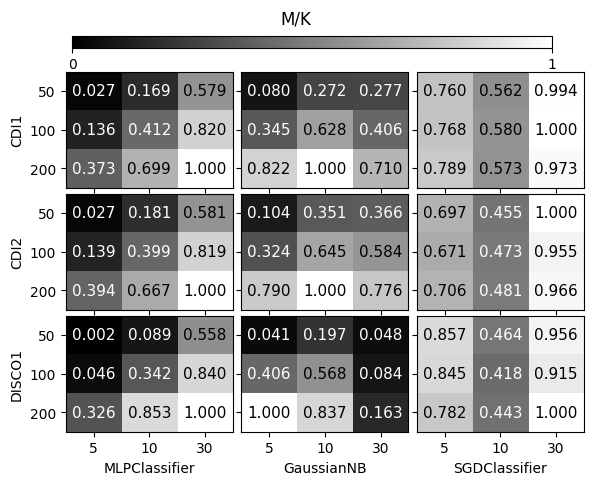

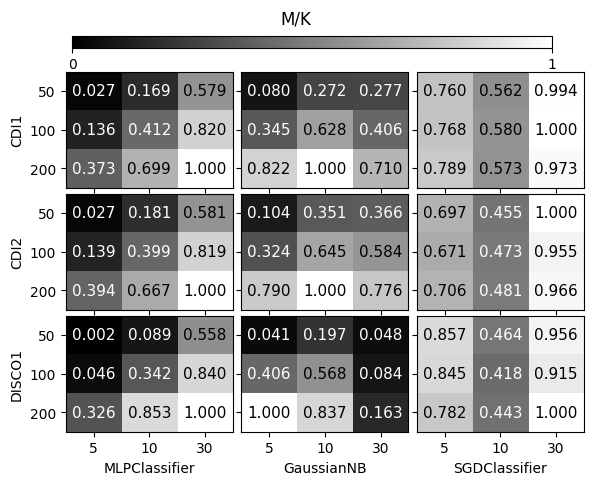

In [175]:
def calc_pval_table_for(df, clf, param_1, param_2):
    filtered_df = find_max_for_params(df, clf, param_1, param_2)
    best = filtered_df.sort_values(by='avg', ascending=False).head(1)
    best_p1, best_p2 = best[param_1].values[0], best[param_2].values[0]
    v_1, v_2 = parameters[param_1], parameters[param_2]
    best_scores = best[streams].to_numpy()[0]
    current_avg = np.nanmean(best_scores)
    best_scores = np.where(np.isnan, best_scores, current_avg)
    t_stats = np.zeros((len(v_1), len(v_2)))

    for i, p1 in enumerate(v_1):
        for j, p2 in enumerate(v_2):
            if p1 == best_p1 and p2 == best_p2:
                t_stats[i, j] = 1
            else:
                current_df = filtered_df[(filtered_df[param_1] == p1) & (filtered_df[param_2] == p2)]
                current = current_df[streams].to_numpy()[0]
                current_avg = np.nanmean(current)
                current = np.where(np.isnan, current, current_avg)
                p_value = ttest_ind(best_scores, current, nan_policy='omit')[1]
                t_stats[i, j] = p_value
    return t_stats.T


def calculate_scores_table_for(df, clf, param_1, param_2):
    filtered_df = find_max_for_params(df, clf, param_1, param_2)
    best = filtered_df.sort_values(by='avg', ascending=False).head(1)
    best_p1, best_p2 = best[param_1].values[0], best[param_2].values[0]
    v_1, v_2 = parameters[param_1], parameters[param_2]
    best_scores = best[streams].to_numpy()[0]
    current_avg = np.nanmean(best_scores)
    best_scores = np.where(np.isnan, best_scores, current_avg)
    scores = np.empty((len(v_1), len(v_2)), dtype=object)

    for i, p1 in enumerate(v_1):
        for j, p2 in enumerate(v_2):
            if p1 == best_p1 and p2 == best_p2:
                x = f'{best["avg"].to_numpy()[0]:.3f}'
                scores[i, j] = ("\\textbf{" + x + "}").rjust(13, ' ')
            else:
                current_df = filtered_df[(filtered_df[param_1] == p1) & (filtered_df[param_2] == p2)]
                current = current_df[streams].to_numpy()[0]
                current_avg = np.nanmean(current)
                current = np.where(np.isnan, current, current_avg)
                p_value = ttest_ind(best_scores, current, nan_policy='omit')[1]
                if p_value < 0.05:
                    scores[i, j] = f'{current_df["avg"].to_numpy()[0]:.3f}'.rjust(13, ' ')
                else:
                    x = f'{current_df["avg"].to_numpy()[0]:.3f}'
                    scores[i, j] = ("\\textbf{" + x + "}").rjust(13, ' ')
    return scores.T

def draw_table_for_param_pair(df, x_param, y_param, fontsize=8):
    stream_results = {}
    for stream, alias in streams_and_aliases:
        stream_results[stream] = df[df['stream'] == stream].sort_values(by=['avg'], ascending=False)

    p_values_table = np.array([
        [
            calc_pval_table_for(stream_results[stream], base, x_param, y_param)
            for base in parameters['base']
        ] for stream, alias in streams_and_aliases
    ])
    aliases = [alias for stream, alias in streams_and_aliases]
    return draw_big_table(p_values_table, parameters[x_param], parameters[y_param], parameters['base'], aliases,
                          title=f'{params_translations[x_param]}/{params_translations[y_param]}', fontsize=fontsize)

draw_table_for_param_pair(all_files_data, 'n', 'k', fontsize=11)


In [176]:
combinables = [combinable for combinable in list(parameters.keys()) if combinable != 'base']
combinations = []
for i in range(len(combinables)):
    for j in range(i + 1, len(combinables)):
        combinations.append((combinables[i], combinables[j]))
combinations

[('p', 'n'), ('p', 'k'), ('p', 'w'), ('n', 'k'), ('n', 'w'), ('k', 'w')]

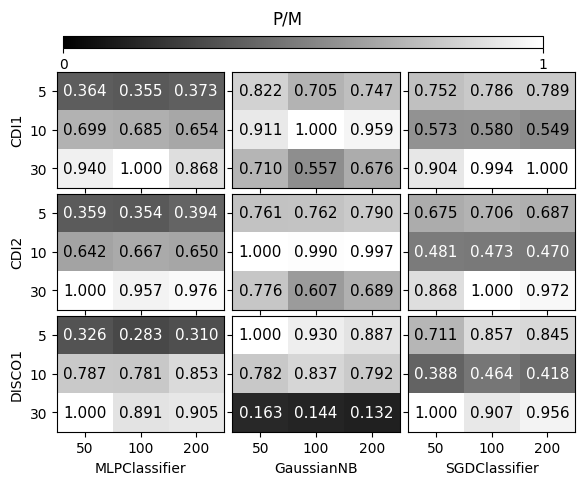

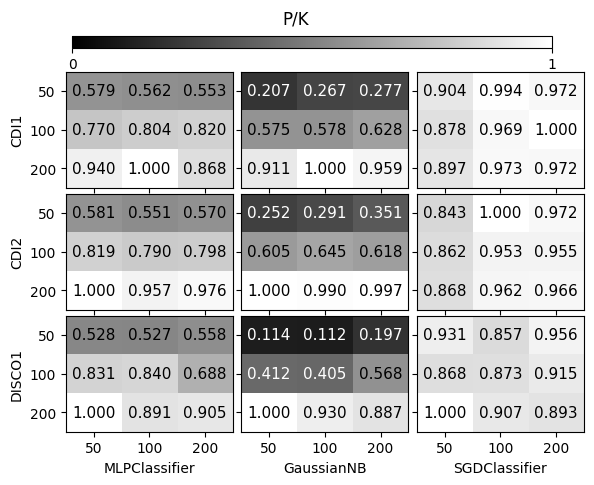

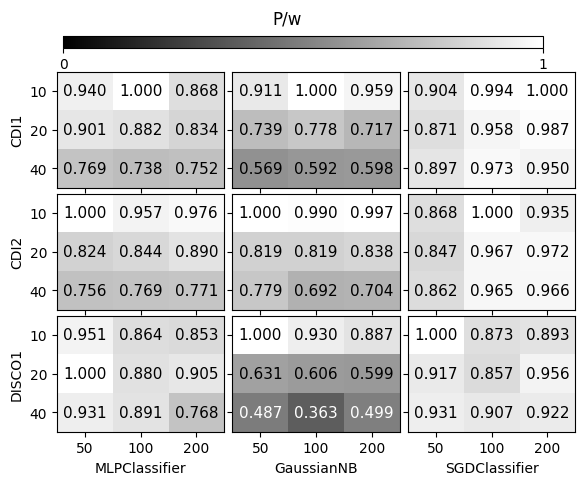

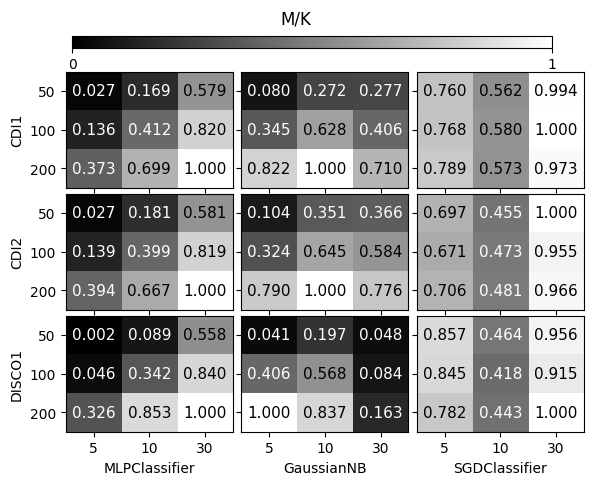

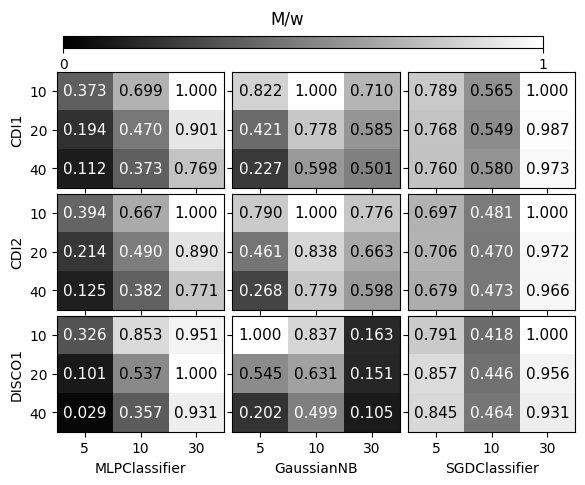

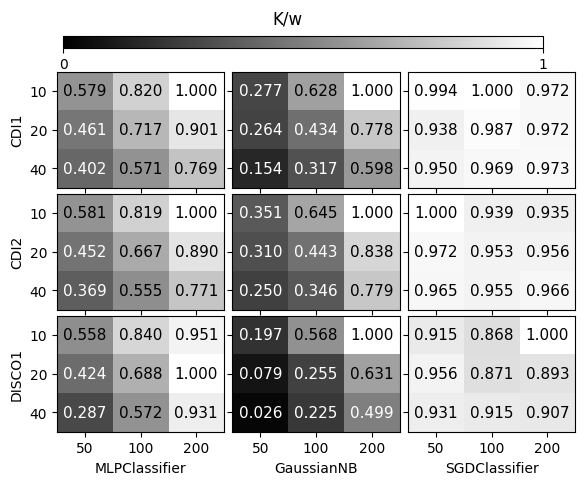

In [177]:
figures = [(f'{x_param}{y_param}', draw_table_for_param_pair(all_files_data, x_param, y_param, fontsize=11)) for x_param, y_param in combinations]
for name, fig in figures:
    fig.savefig(os.path.join(PLOTS_LOCATION, f'{name}.svg'), transparent=True)

In [178]:
scores_table = calculate_scores_table_for(all_files_data[all_files_data['stream'] == all_streams_names[0]],
                                          parameters['base'][0], 'n', 'k')
scores_table

array([['        0.788', '\\textbf{0.808}', '\\textbf{0.825}'],
       ['\\textbf{0.805}', '\\textbf{0.819}', '\\textbf{0.831}'],
       ['\\textbf{0.818}', '\\textbf{0.828}', '\\textbf{0.836}']],
      dtype=object)

In [179]:
def join_table(table, row_headers, group_header):
    first_col = np.full_like(row_headers, '', dtype='object')
    first_col[0] = ('\\multirow{' + str(len(row_headers)) + '}{*}{\\rotatebox[origin=c]{90}{' + group_header + '}}')
    return ' \\\\ \n'.join([' & '.join(_row) for _row in
                            np.concatenate((np.array([first_col]).T, np.array([row_headers]).T, table.astype(str)), axis=1)])


def prepare_c_mid_rules(_pv1, _scores):
    cline_start = 3
    c_lines = [(cline_start * (_i + 1), cline_start * (_i + 1) + len(_pv1) - 1) for _i in range(_scores.shape[1])]
    c_mid_rules = ' '.join(['\\cmidrule{' + str(cline[0]) + '-' + str(cline[1]) + '}' for cline in c_lines])
    return c_mid_rules


def prepare_columns_subheader(_pv1, _scores):
    acc = []
    for _i in range(_scores.shape[1] - 1):
        tmp = ''
        for _v1 in _pv1[:-1]:
            tmp += '\\multicolumn{1}{c}{' + str(_v1) + '} & '
        tmp += '\\multicolumn{1}{c|}{' + str(_pv1[-1]) + '}'
        acc.append(tmp)
    acc.extend(['\\multicolumn{1}{c}{' + str(_v1) + '}' for _v1 in _pv1])
    return ' & '.join(acc)


def prepare_scores_table(df, x_param, y_param):
    stream_results = {}
    for stream, alias in streams_and_aliases:
        stream_results[stream] = df[df['stream'] == stream].sort_values(by=['avg'], ascending=False)

    _scores = np.array([
        [
            calculate_scores_table_for(stream_results[stream], base, x_param, y_param)
            for base in parameters['base']
        ] for stream, alias in streams_and_aliases
    ])
    aliases = [alias for stream, alias in streams_and_aliases]
    _pv1, _pv2 = parameters[x_param], parameters[y_param]

    columns_def = 'll' + (_scores.shape[1] * ('|' + len(_pv1) * 'l'))
    environment_start = '\\subfloat[{ ' + params_translations_full[x_param] + '/' + params_translations_full[y_param] + '}]{\n'\
                        '\t\\label{tbl:ex1:'+ x_param + y_param + '}\n' \
                        ' \n\t\\begin{tabular}{' + columns_def + '}'

    _header = f'{environment_start} \n' \
              f'\\toprule' \
              f' & ${params_translations[y_param]}$ & {prepare_table_upper_header(_pv1)} \\\\ \n' \
              f' ${params_translations[x_param]}$ & & {prepare_columns_subheader(_pv1, _scores)} \\\\ \n' \
              f' {prepare_c_mid_rules(_pv1, _scores)} \n'

    row_headers = np.array(_pv2).astype('str')
    tables = []
    for _i, _current_row in enumerate(_scores):
        _tmp = _current_row[0]
        for _current_table in _current_row[1:]:
            _tmp = np.concatenate((_tmp, _current_table), axis=1)
        tables.append(join_table(_tmp, row_headers, aliases[_i]) + ' \\\\ \n')
    return _header + '\\midrule\n'.join(tables) + \
        ' \\bottomrule \n' \
        '\t\\end{tabular}} \n' \



def prepare_table_upper_header(_pv1):
    return (' & '.join([
        "\\multicolumn{" + f"{len(_pv1)}" + "}{c}{" + clf + "}" for clf in parameters['base']
    ]))


In [180]:
def prepare_table_in_file(df, x_param, y_param):
    with open(os.path.join(TBLS_LOCATION, f'{x_param}{y_param}'), mode='w+', encoding='utf8') as f:
        f.write(prepare_scores_table(df, x_param, y_param))

In [181]:
for xp, yp in combinations:
    prepare_table_in_file(all_files_data, xp, yp)

In [182]:
all_files_data

,n,p,w,k,base,stream,1000,100000,101010,10110,101101,1001,10101010,101,110,1337,avg
0,10,100,10,100,GaussianNB,"cdi__w2_4_0,9__NC_250__CS_200",0.863961,0.830409,0.831684,0.749153,0.793336,0.779023,0.840580,0.853465,0.857029,0.773289,0.817193
1,10,100,10,100,GaussianNB,"cdi__w2_5_0,75__NC_250__CS_200",0.882234,0.851343,0.854128,0.767646,0.806554,0.799372,0.860912,0.871603,0.883611,0.802982,0.838039
2,10,100,10,100,MLPClassifier,"cdi__w2_4_0,9__NC_250__CS_200",0.882455,0.812346,0.830928,0.757676,0.781909,0.776283,0.856243,0.851473,0.868897,0.768406,0.818662
3,10,100,10,100,MLPClassifier,"cdi__w2_5_0,75__NC_250__CS_200",0.895605,0.834805,0.849106,0.769150,0.802582,0.799525,0.877997,0.871990,0.887718,0.793079,0.838156
4,10,100,10,100,SGDClassifier,"cdi__w2_4_0,9__NC_250__CS_200",0.831989,0.730126,0.782838,0.719361,0.745018,0.737306,0.829030,0.801763,0.829551,0.705653,0.771264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,5,50,40,200,MLPClassifier,"disco__w2_5_0,9__NC_250__CS_200",0.774517,0.736057,0.806959,0.812651,0.809883,0.788639,0.809972,0.782493,0.842947,0.811434,0.797555
725,5,50,40,200,SGDClassifier,"disco__w2_5_0,9__NC_250__CS_200",0.774771,0.739670,0.812083,0.817211,0.807591,0.775372,0.815633,0.768712,NaN,0.804561,0.790623
726,5,50,40,50,GaussianNB,"disco__w2_5_0,9__NC_250__CS_200",0.727546,0.698483,0.771735,0.780591,0.783961,0.734622,0.767337,0.736068,0.811271,0.770436,0.758205
727,5,50,40,50,MLPClassifier,"disco__w2_5_0,9__NC_250__CS_200",0.724709,0.685949,0.752758,0.761184,0.744185,0.733455,0.752411,0.728427,0.800268,0.755812,0.743916


In [183]:
def find_best(df: pd.DataFrame, base: str, stream: str):
    _by_clf = df[(df['base'] == base) & (df['stream'] == stream)].drop(columns=streams)
    _sorted = _by_clf.sort_values(by='avg', ascending=False).head(1)
    return _sorted

acc = pd.DataFrame()
for base in parameters['base']:
    for stream in all_streams_names:
        acc = pd.concat([acc, find_best(all_files_data, base, stream)], axis=0)
dicts = acc.reset_index().drop(columns=['index']).to_dict(orient='records')
tmp = {}
for record in dicts:
    current_stream = record['stream']
    base_clf = record['base']
    if current_stream in tmp:
        tmp[current_stream][base_clf] = {
                'n': record['n'],
                'p': record['p'],
                'k': record['k'],
                'w': record['w']
            }
    else:
        tmp[current_stream] = {
            record['base']: {
                'n': record['n'],
                'p': record['p'],
                'k': record['k'],
                'w': record['w']
            }
        }
pd.DataFrame(list(tmp.items()))

,"cdi__w2_4_0,9__NC_250__CS_200","cdi__w2_5_0,75__NC_250__CS_200","disco__w2_5_0,9__NC_250__CS_200"
MLPClassifier,"{'n': 30, 'p': 100, 'k': 200, 'w': 10}","{'n': 30, 'p': 50, 'k': 200, 'w': 10}","{'n': 30, 'p': 50, 'k': 200, 'w': 20}"
GaussianNB,"{'n': 10, 'p': 100, 'k': 200, 'w': 10}","{'n': 10, 'p': 50, 'k': 200, 'w': 10}","{'n': 5, 'p': 50, 'k': 200, 'w': 10}"
SGDClassifier,"{'n': 30, 'p': 200, 'k': 100, 'w': 10}","{'n': 30, 'p': 100, 'k': 50, 'w': 10}","{'n': 30, 'p': 50, 'k': 200, 'w': 10}"


In [184]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier

dataset = load_iris()
data = dataset['data']
target = dataset['target']

mlp = MLPClassifier()

classes = np.unique(target)


In [185]:
x = np.random.normal(size=(3,3,3))
np.concatenate((x[0], x[1], x[2]), axis=1)

array([[ 1.06855028, -0.38507909, -2.88709441, -1.0225983 , -1.31169986,
        -0.74598914, -1.06978872, -1.5313768 , -1.15470504],
       [ 1.71583201,  0.59360302, -2.53822341, -1.28286613, -0.68994482,
         0.54501665, -1.87311388, -0.44411366,  1.61805272],
       [-1.32514029, -0.24678891, -0.7910861 , -0.3455099 ,  1.72361995,
        -1.63050883,  0.10450113, -0.49139272, -1.03193466]])

In [186]:
t = x[0]
for xx in x[1:]:
    t = np.concatenate((t, xx), axis=1)
t

array([[ 1.06855028, -0.38507909, -2.88709441, -1.0225983 , -1.31169986,
        -0.74598914, -1.06978872, -1.5313768 , -1.15470504],
       [ 1.71583201,  0.59360302, -2.53822341, -1.28286613, -0.68994482,
         0.54501665, -1.87311388, -0.44411366,  1.61805272],
       [-1.32514029, -0.24678891, -0.7910861 , -0.3455099 ,  1.72361995,
        -1.63050883,  0.10450113, -0.49139272, -1.03193466]])